In [1]:
import os
import os.path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

print("pandas version:", pd.__version__)

pandas version: 1.3.5


In [2]:
drive.mount("/content/drive")
BASE_DIR = "drive/Shareddrives/PECSN/simulation_data/"
x = 42

Mounted at /content/drive


In [3]:
def getFilesNames(data_folder = ".", pattern = '^Warmuptime-#(?P<number>\d+).vec.csv$'):
    cwd = os.getcwd()
    # dir where search data files
    datadir = os.path.join(cwd, data_folder)
    if not os.path.isdir(datadir):
        print("Invalid path!")
        exit(1)
    file_re = re.compile(pattern)
    files = {int(file_re.search(fname).group('number')):os.path.join(datadir, fname) for fname in os.listdir(datadir) if file_re.search(fname)}
    return files

def getTable(fpath):
    """Read the CSV file and return contained data"""
    table = pd.read_csv(fpath)
    return table

def getAllTables(d):
    """Receive dicionary {repNum:file} and return dictionary {repNum:table}"""
    ans = {}
    for k in d:
        ans[k] = getTable(d[k])
    return ans

class RunData:
    def run(self, table):
        """GET 'run' parameter from CSV"""
        if table['run'].value_counts().size == len(table.index):
            print("Multiple 'run' values in table!")
            exit(1)
        else:
            self.run = table['run'][0]
    
    def module(self, table):
        """GET 'module' parameter from CSV"""
        gb = table.groupby(['module'])
        if len(gb.groups) != 1:
            print("Multiple 'module' values in table!")
            exit(1)
        else:
            self.module = list(gb.indices.keys())[0]
    
    def runattr(self, table):
        """Get all 'runattr' parameters from CSV"""
        self.runattr = {}
        ra = table[table['type'] == 'runattr']
        for index,row in ra.iterrows():
            self.runattr[row['attrname']] = row['attrvalue']
    
    def param(self, table):
        """Get all 'param' parameters from CSV"""
        self.param = {}
        ra = table[table['type'] == 'param']
        for index,row in ra.iterrows():
            self.param[row['attrname']] = row['attrvalue']
    
    def vecInfo(self, table, indexes):
        ans = {'vector':{}, 'attr':{}}
        for i in indexes:
            # get row
            row = table.loc[i]
            # get params
            if row.type == 'vector':
                data = {
                    'time': np.fromiter(row.vectime.split(),float),
                    'value': np.fromiter(row.vecvalue.split(),float),
                }
                ans['vector'] = data
            elif row.type == 'attr':
                ans['attr'][row.attrname] = row.attrvalue
        return ans
    
    def vectors(self, table):
        self.vectors = {}
        values = table[table['module'] == self.module]
        gb = values.groupby(['name'])
        for k,v in gb.groups.items():
            self.vectors[k] = self.vecInfo(table, v)
    
    def __init__(self, table):
        # simple kv parameters
        self.run(table)
        self.module(table)
        # dict parameters
        self.runattr(table)
        self.param(table)
        # vector parameters
        self.vectors(table)
        

def tableToObject(table):
    return RunData(table)

def tablesToObjects(tables):
    ans = {}
    for k,v in tables.items():
        ans[k] = tableToObject(v)
    return ans

def allVectorNames(objs):
    """Find all vector names. args is a dict {iterNum:RunData}"""
    names = set()
    for v in objs.values():
        for n in v.vectors.keys():
            names.add(n)
    return names

def plotVector(ax, name, obj, x_min=-np.inf, x_max=np.inf):
    """Plot vector identified by the name on ax"""
    """x_min and x_max identify the range to plot"""
    if name not in obj.vectors:
        # vector not found!
        return
    # get vector
    vec = obj.vectors[name]['vector']
    # perform slicing
    indexes = (x_min <= vec['time']) & (vec['time'] <= x_max)
    x = vec['time'][indexes]
    y = vec['value'][indexes]
    # plot vector
    ax.plot(x, y)

def plotVectors(objs, x_min=-np.inf, x_max=np.inf):
    """One plot for each vector name with one line for each iteration"""
    # get the titles of all vectors
    plotNames = allVectorNames(objs)
    # create figure
    # doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots
    fig, axs = plt.subplots(len(plotNames), figsize=(9, 9))
    # iterate over pairs (ax,name)
    # example: https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html#sphx-glr-gallery-images-contours-and-fields-interpolation-methods-py
    for ax,name in zip(axs.flat, plotNames):
        ax.set_title(name)
        # for each object
        for obj in objs.values():
            plotVector(ax, name, obj, x_min=x_min, x_max=x_max)
    fig.tight_layout()
    fig.show()

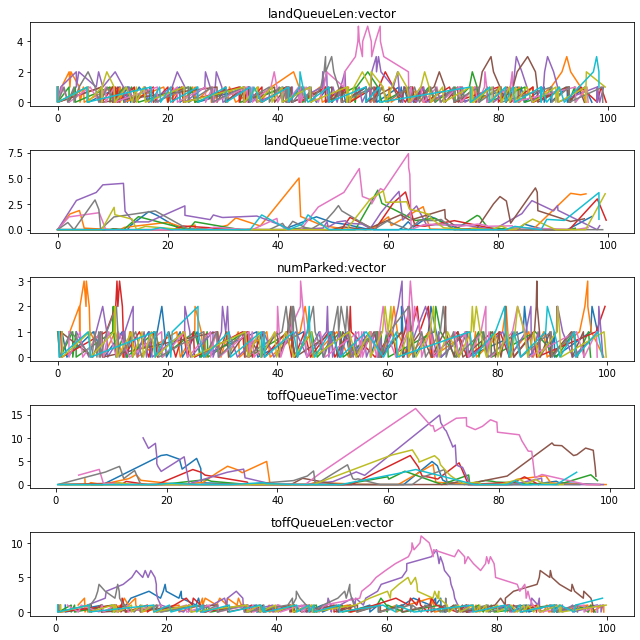

In [4]:
# 
files = getFilesNames(BASE_DIR)
tables = getAllTables(files)
objs = tablesToObjects(tables)
plotVectors(objs, x_max=100)